In [ ]:
import os
import copy
import json
from collections import Counter

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from torchvision.models import resnet18

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
   mean_squared_error, r2_score, 
   accuracy_score, precision_score, 
   recall_score, f1_score, roc_auc_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import xgboost as xgb
import optuna

from house_dataset import HouseRegressionData

## Train for Classification First and then Regression

In [ ]:
# Convert house price to log scale
train_data = pd.read_csv('train_set_1.csv')
train_data['log_price'] = np.log(train_data['price'])
train_data.to_csv('train_set_1_log.csv', index=False)

test_data = pd.read_csv('val_set_1.csv')
test_data['log_price'] = np.log(test_data['price'])
test_data.to_csv('val_set_1_log.csv', index=False)

# Split the training data into train and validation subsets bc our test in this case is our pre split val
train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=42)

# Save files as a csv
train_df.to_csv('train_split.csv', index=False)
val_df.to_csv('val_split.csv', index=False)

# CSV paths
train_csv_file = 'train_split.csv'
val_csv_file = 'val_split.csv'
test_csv_file = 'val_set_1_log.csv'
image_folder = 'socal_pics'

price_threshold = np.log(650000)

# Ideal resnet sizes
transform = transforms.Compose([
    transforms.Resize((224, 224)),             
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])  
])


# Datasets for classification
train_dataset_class = HouseRegressionData(
    csv_file=train_csv_file, 
    image_folder=image_folder, 
    price_col="log_price", 
    transform=transform,  
    classification=True, 
    threshold=price_threshold
)

val_dataset_class = HouseRegressionData(
    csv_file=val_csv_file, 
    image_folder=image_folder, 
    price_col="log_price", 
    transform=transform, 
    classification=True, 
    threshold=price_threshold
)

test_dataset_class = HouseRegressionData(
    csv_file=test_csv_file, 
    image_folder=image_folder, 
    price_col="log_price", 
    transform=transform,  
    classification=True, 
    threshold=price_threshold
)

# Create loaders 
# This batch size works on my computer
batch_size = 32
train_loader_class = DataLoader(train_dataset_class, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader_class = DataLoader(val_dataset_class, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader_class = DataLoader(test_dataset_class, batch_size=batch_size, shuffle=False, num_workers=4)

# Check to see that everything loaded correctly
for images, labels in train_loader_class:
    print(f"Image batch shape: {images.shape}")
    print(f"Binary class batch shape: {labels.shape}")
    break

print(f"Training dataset size: {len(train_dataset_class)}")
print(f"Validation dataset size: {len(val_dataset_class)}")
print(f"Validation dataset size: {len(test_dataset_class)}")



Image batch shape: torch.Size([32, 3, 224, 224])
Binary class batch shape: torch.Size([32])
Training dataset size: 6978
Validation dataset size: 1745
Validation dataset size: 2181


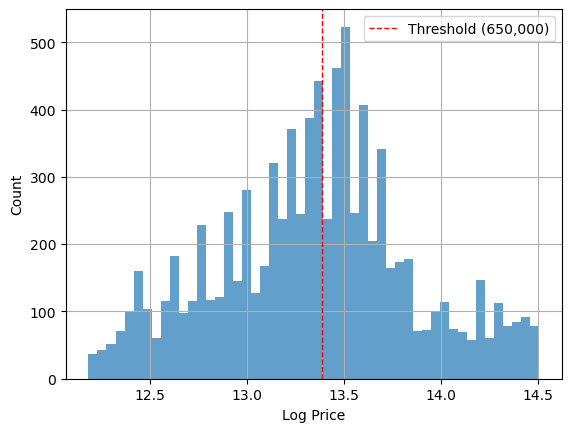

In [ ]:
# this is how i figured out the split
train_data['log_price'].hist(bins=50, alpha=0.7)
plt.axvline(np.log(650000), color='red', linestyle='dashed', linewidth=1, label='Threshold (650,000)')
plt.xlabel('Log Price')
plt.ylabel('Count')
plt.legend()
plt.show()


In [ ]:
# what is the percentage of each class?
new_threshold = np.log(650000)
train_data['class'] = (train_data['log_price'] >= new_threshold).astype(int)
class_counts = Counter(train_data['class'])

print(f"Class 0: {class_counts[0]} samples ({class_counts[0] / sum(class_counts.values()):.2%})")
print(f"Class 1: {class_counts[1]} samples ({class_counts[1] / sum(class_counts.values()):.2%})")



Class 0: 4496 samples (51.54%)
Class 1: 4227 samples (48.46%)


## Classification using resnet

In [ ]:
# resnet for classification
device = torch.device('cpu')

resnet_class = resnet18(pretrained=True)
num_features = resnet_class.fc.in_features
resnet_class.to(device)

# Change the output bc we only have two classes
resnet_class.fc = nn.Linear(num_features, 1)  

# this is the recomended loss function for resnet
# Started with .001 bc this is where I saw the most stability
loss_fn = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(resnet_class.parameters(), lr=0.001)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


: 

In [ ]:
# I don't have a gpu so device it is
resnet_class.to(device)

# Train and validation losses for the plot after training
train_losses = []
val_losses = []

n_epochs = 10

# Only want to train the weights in the final layer
for name, param in resnet_class.named_parameters():
    if 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Patience of 2 since we are only using 10 epochs
early_stop_patience = 2
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(n_epochs):
    resnet_class.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    with tqdm(total=len(train_loader_class), desc=f"Epoch {epoch+1}/{n_epochs} (Classification)") as pbar:
        for images, labels in train_loader_class:
            images, labels = images.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = resnet_class(images).squeeze()

            # Use loss function which is binary cross entropy
            loss = loss_fn(outputs, labels)
            loss.backward()

            # optimizer is adam
            optimizer.step()

            running_loss += loss.item()

            # Convert logits to probabilities for binary classification
            preds = torch.round(torch.sigmoid(outputs))
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

            # Progress bar
            pbar.update(1)
            pbar.set_postfix(batch_loss=loss.item())

    train_loss = running_loss / len(train_loader_class)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)  
    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation loop
    resnet_class.eval()
    val_loss_class = 0.0
    correct_val_class = 0
    total_val_class = 0

    # Repeat all steps without gradient calculation to test on the validation set
    with torch.no_grad():
        for images, labels in val_loader_class:
            images, labels = images.to(device), labels.to(device).float()
            outputs = resnet_class(images).squeeze()
            loss = loss_fn(outputs, labels)
            val_loss_class += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            correct_val_class += (preds == labels).sum().item()
            total_val_class += labels.size(0)

    val_loss_class /= len(val_loader_class)
    val_accuracy = correct_val_class / total_val_class
    val_losses.append(val_loss_class)  # Store validation loss
    print(f"Epoch {epoch+1}/{n_epochs}, Validation Loss: {val_loss_class:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping logic
    if val_loss_class < best_val_loss:
        best_val_loss = val_loss_class
        epochs_no_improve = 0
        torch.save(resnet_class.state_dict(), 'best_resnet_model.pth')
        print("Validation loss improved, saving model.")
    else:
        epochs_no_improve += 1
        print(f"No improvement in validation loss for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= early_stop_patience:
        print("Early stopping triggered!")
        break

    # Save model checkpoint for each epoch
    torch.save(resnet_class.state_dict(), f'resnet_epoch_{epoch+1}.pth')
    print(f"Model checkpoint saved for epoch {epoch+1}.")


Epoch 1/10 (Classification): 100%|██████████| 219/219 [03:44<00:00,  1.03s/it, batch_loss=0.575]

Epoch 1/10, Training Loss: 0.6526, Training Accuracy: 0.6129


Epoch 1/10, Validation Loss: 0.6436, Validation Accuracy: 0.6292
Validation loss improved, saving model.
Model checkpoint saved for epoch 1.


Epoch 2/10 (Classification): 100%|██████████| 219/219 [03:59<00:00,  1.09s/it, batch_loss=0.688]

Epoch 2/10, Training Loss: 0.6232, Training Accuracy: 0.6505


Epoch 2/10, Validation Loss: 0.6305, Validation Accuracy: 0.6516
Validation loss improved, saving model.
Model checkpoint saved for epoch 2.


Epoch 3/10 (Classification): 100%|██████████| 219/219 [04:21<00:00,  1.19s/it, batch_loss=0.305]

Epoch 3/10, Training Loss: 0.6046, Training Accuracy: 0.6694


Epoch 3/10, Validation Loss: 0.6303, Validation Accuracy: 0.6533
Validation loss improved, saving model.
Model checkpoint saved for epoch 3.


Epoch 4/10 (Classification): 100%|██████████| 219/219 [04:14<00:00,  1.16s/it, batch_loss=0.567]

Epoch 4/10, Training Loss: 0.6036, Training Accuracy: 0.6728


Epoch 4/10, Validation Loss: 0.6388, Validation Accuracy: 0.6378
No improvement in validation loss for 1 epoch(s).
Model checkpoint saved for epoch 4.


Epoch 5/10 (Classification): 100%|██████████| 219/219 [04:31<00:00,  1.24s/it, batch_loss=0.776]

Epoch 5/10, Training Loss: 0.5993, Training Accuracy: 0.6781


Epoch 5/10, Validation Loss: 0.6274, Validation Accuracy: 0.6688
Validation loss improved, saving model.
Model checkpoint saved for epoch 5.


Epoch 6/10 (Classification): 100%|██████████| 219/219 [03:52<00:00,  1.06s/it, batch_loss=0.589]

Epoch 6/10, Training Loss: 0.5930, Training Accuracy: 0.6833


Epoch 6/10, Validation Loss: 0.6518, Validation Accuracy: 0.6258
No improvement in validation loss for 1 epoch(s).
Model checkpoint saved for epoch 6.


Epoch 7/10 (Classification): 100%|██████████| 219/219 [03:48<00:00,  1.04s/it, batch_loss=0.407]

Epoch 7/10, Training Loss: 0.5989, Training Accuracy: 0.6767


Epoch 7/10, Validation Loss: 0.6478, Validation Accuracy: 0.6401
No improvement in validation loss for 2 epoch(s).
Early stopping triggered!


### Learning Curve

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


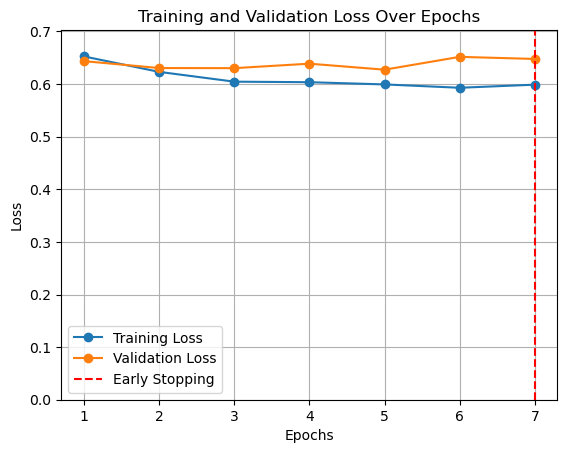

In [ ]:
# Learning curve plot 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.grid(True)

# We have to manually set this
early_stopping_epoch = 7 
plt.axvline(x=early_stopping_epoch, color='red', linestyle='--', label='Early Stopping')
plt.legend()

# Set the upper bound of the y axis as the maximum loss value
max_loss = max(max(train_losses), max(val_losses))
plt.ylim(0, max(max(train_losses), max(val_losses)) + 0.05)
plt.show()


### Evaluate on the test set

In [ ]:
torch.save(resnet_class.state_dict(), "resnet_classification.pth")
# saved just in case here, but it should save the best weights in the training loop

In [ ]:
# Initialize metrics
all_labels = []
all_predictions = []
all_probabilities = []

# Set to evaluaton
resnet_class.eval()
with torch.no_grad():
    for images, labels in test_loader_class:
        images, labels = images.to(device), labels.to(device).float()

        # Convert logits to probabilities using sigmoid
        outputs = resnet_class(images).squeeze()
        probabilities = torch.sigmoid(outputs)

        # Threshold set to .5 - converts to binary classes, could also use rounding
        predictions = (probabilities > 0.5).float()

        # Save labels, predictions, and probabilities
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)

# All the important metrics we may need
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
roc_auc = roc_auc_score(all_labels, all_probabilities)  

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")


Accuracy: 0.6470
Precision: 0.6047
Recall: 0.8000
F1-Score: 0.6888
ROC-AUC: 0.7286


### Every plot we could ever need - IDK which ones will be useful

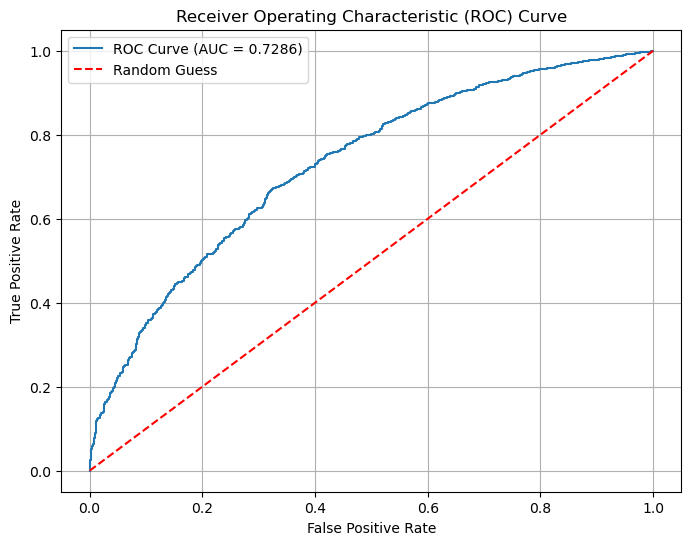

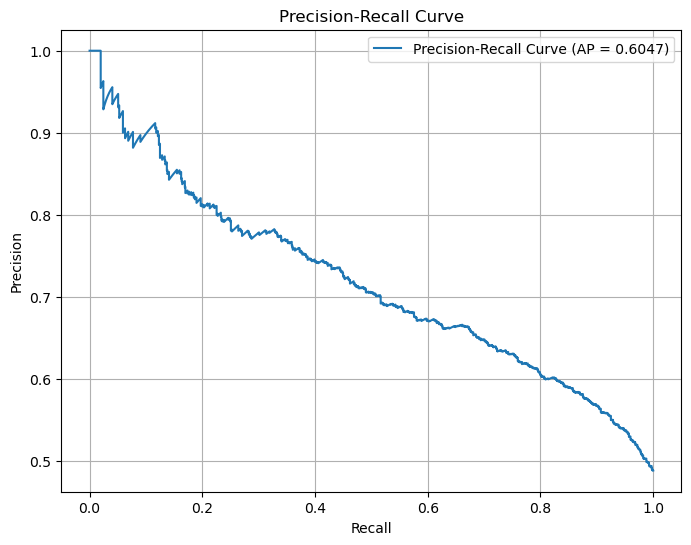

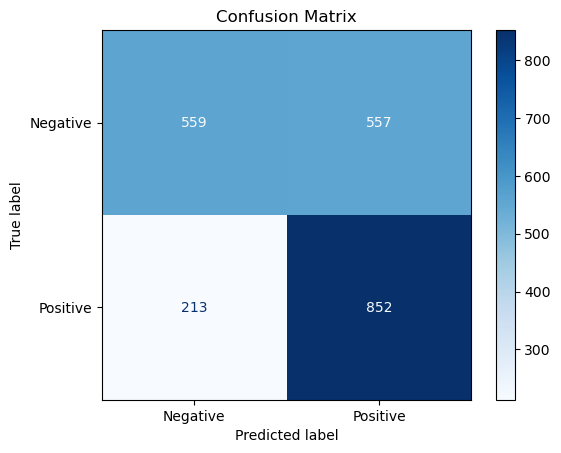

In [ ]:

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probabilities)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'r--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid()
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(all_labels, all_probabilities)
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, label=f"Precision-Recall Curve (AP = {precision:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


## Regression

In [ ]:
# Paths
train_csv_file = 'train_split.csv'
val_csv_file = 'val_split.csv'
test_csv_file = 'val_set_1_log.csv'
image_folder = 'socal_pics'

# Transformation - Same as before - this is what resnet wants
transform = transforms.Compose([
    transforms.Resize((224, 224)),         
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])


# Make sure to set classification to false
train_dataset_reg = HouseRegressionData(
    csv_file=train_csv_file, 
    image_folder=image_folder, 
    price_col="log_price", 
    transform=transform,
    classification=False 
)

val_dataset_reg = HouseRegressionData(
    csv_file=val_csv_file, 
    image_folder=image_folder, 
    price_col="log_price", 
    transform=transform,
    classification=False  
)

test_dataset_reg = HouseRegressionData(
    csv_file=test_csv_file, 
    image_folder=image_folder, 
    price_col="log_price", 
    transform=transform,
    classification=False 
)

# Same batch size as classification
batch_size = 32
train_loader_reg = DataLoader(train_dataset_reg, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader_reg = DataLoader(val_dataset_reg, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader_reg = DataLoader(test_dataset_reg, batch_size=batch_size, shuffle=False, num_workers=4)



In [ ]:
# Don't load the pre-trained weights
resnet_reg = resnet18(pretrained=False)  
num_features = resnet_reg.fc.in_features
resnet_reg.fc = nn.Linear(num_features, 1)  

# These weights are from the class model
resnet_reg.load_state_dict(torch.load('/Users/maggiekleman/Desktop/MSBA/Advanced Machine Learning/Project/resnet_epoch_6.pth'), strict=False)  


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


: 

: 

In [ ]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(resnet_reg.parameters(), lr=0.001)

#  fine-tune fc and layer 4
for name, param in resnet_reg.named_parameters():
    if "fc" in name or "layer4" in name:
        param.requires_grad = True  
    else:
        param.requires_grad = False  #

In [ ]:
# Same structure as the previous implementation but just for regression
train_losses = []
train_r2_scores = []
val_losses = []
val_r2_scores = []

# Early stopping variables
patience = 2
best_val_loss = float('inf')
epochs_without_improvement = 0

# Training loop
for epoch in range(n_epochs):
    resnet_reg.train()
    running_loss = 0.0
    train_preds = []
    train_targets = []
    
    with tqdm(train_loader_reg, desc=f"Epoch {epoch+1}/{n_epochs} (Regression)") as pbar:
        for images, log_prices in pbar:
            images, log_prices = images.to(device), log_prices.to(device).float()
            optimizer.zero_grad()
            outputs = resnet_reg(images).squeeze()
            loss = loss_fn(outputs, log_prices)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            # Store variables
            train_preds.extend(outputs.detach().cpu().numpy())
            train_targets.extend(log_prices.cpu().numpy())
            
            pbar.set_postfix(batch_loss=loss.item())

    # Debugging: Print predictions and targets for training
    train_preds = np.array(train_preds)
    train_targets = np.array(train_targets)

    
    # training loss and R^2 for this epoch - 
    train_loss = running_loss / len(train_loader_reg)
    train_r2 = r2_score(train_targets, train_preds)
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2)
    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_loss:.4f}, Training R^2: {train_r2:.4f}")

    # Validation loop
    resnet_reg.eval()
    val_loss_reg = 0.0
    val_preds_reg = []
    val_targets_reg = []
    
    with torch.no_grad():
        for images, log_prices in val_loader_reg:
            images, log_prices = images.to(device), log_prices.to(device).float()
            outputs = resnet_reg(images).squeeze()
            loss = loss_fn(outputs, log_prices)
            val_loss_reg += loss.item()
            

            val_preds_reg.extend(outputs.cpu().numpy())
            val_targets_reg.extend(log_prices.cpu().numpy())
    
    # I just wanted to show these as it trained 
    val_loss_reg /= len(val_loader_reg)
    val_r2_reg = r2_score(val_targets_reg, val_preds_reg)
    val_losses.append(val_loss_reg)
    val_r2_scores.append(val_r2_reg)
    print(f"Epoch {epoch+1}/{n_epochs}, Validation Loss: {val_loss_reg:.4f}, Validation R^2: {val_r2_reg:.4f}")

    # Early stopping 
    if val_loss_reg < best_val_loss:
        best_val_loss = val_loss_reg
        epochs_without_improvement = 0
        best_model_state = copy.deepcopy(resnet_reg.state_dict())  
        print(f"Validation loss improved to {val_loss_reg:.4f}, saving model.")
    else:
        epochs_without_improvement += 1
        print(f"No improvement in validation loss for {epochs_without_improvement} epoch(s).")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered. Stopping training after {epoch+1} epochs.")
        break

# Best model is loaded
resnet_reg.load_state_dict(best_model_state)
print("Loaded the best model based on validation loss.")



Epoch 1/10 (Regression): 100%|██████████| 219/219 [04:48<00:00,  1.32s/it, batch_loss=0.0666]

Sample Train Predictions (Epoch 1): [-0.224362   -0.83742505  0.40632585 -0.24250835 -0.37211028]
Sample Train Targets (Epoch 1): [13.592242 13.028052 12.560245 13.451667 14.115615]
Epoch 1/10, Training Loss: 6.3461, Training R^2: -23.6963


Epoch 1/10, Validation Loss: 0.2544, Validation R^2: -0.0110
Validation loss improved to 0.2544, saving model.


Epoch 2/10 (Regression): 100%|██████████| 219/219 [05:02<00:00,  1.38s/it, batch_loss=0.148] 

Sample Train Predictions (Epoch 2): [13.364969 13.184015 13.177431 13.470749 13.417379]
Sample Train Targets (Epoch 2): [13.30285  13.017003 12.180755 13.710026 13.122164]
Epoch 2/10, Training Loss: 0.1815, Training R^2: 0.2963


Epoch 2/10, Validation Loss: 0.2458, Validation R^2: 0.0252
Validation loss improved to 0.2458, saving model.


Epoch 3/10 (Regression): 100%|██████████| 219/219 [04:51<00:00,  1.33s/it, batch_loss=0.47]  

Sample Train Predictions (Epoch 3): [12.782213 13.160254 13.358738 13.557829 13.449331]
Sample Train Targets (Epoch 3): [12.706545 13.176851 13.337314 13.319573 13.989464]
Epoch 3/10, Training Loss: 0.1299, Training R^2: 0.5022


Epoch 3/10, Validation Loss: 0.2193, Validation R^2: 0.1273
Validation loss improved to 0.2193, saving model.


Epoch 4/10 (Regression): 100%|██████████| 219/219 [05:14<00:00,  1.44s/it, batch_loss=0.297] 

Sample Train Predictions (Epoch 4): [13.740275 13.0215   13.488095 13.24854  13.984544]
Sample Train Targets (Epoch 4): [13.30793  12.341477 13.217492 13.171153 13.955273]
Epoch 4/10, Training Loss: 0.0822, Training R^2: 0.6850


Epoch 4/10, Validation Loss: 0.1961, Validation R^2: 0.2188
Validation loss improved to 0.1961, saving model.


Epoch 5/10 (Regression): 100%|██████████| 219/219 [05:05<00:00,  1.40s/it, batch_loss=0.105] 

Sample Train Predictions (Epoch 5): [13.408427 13.998855 13.381549 13.292665 13.049216]
Sample Train Targets (Epoch 5): [12.818552 13.764217 13.380101 13.217673 13.058358]
Epoch 5/10, Training Loss: 0.0599, Training R^2: 0.7686


Epoch 5/10, Validation Loss: 0.1724, Validation R^2: 0.3134
Validation loss improved to 0.1724, saving model.


Epoch 6/10 (Regression): 100%|██████████| 219/219 [05:47<00:00,  1.58s/it, batch_loss=0.172] 

Sample Train Predictions (Epoch 6): [12.963231 12.474255 12.798372 14.229926 13.089939]
Sample Train Targets (Epoch 6): [12.660328 12.604177 12.611505 14.345551 12.99453 ]
Epoch 6/10, Training Loss: 0.0453, Training R^2: 0.8265


Epoch 6/10, Validation Loss: 0.1662, Validation R^2: 0.3382
Validation loss improved to 0.1662, saving model.


Epoch 7/10 (Regression): 100%|██████████| 219/219 [05:20<00:00,  1.46s/it, batch_loss=0.0299] 

Sample Train Predictions (Epoch 7): [12.502642 12.423763 14.062944 12.400658 12.977068]
Sample Train Targets (Epoch 7): [12.611204 12.762827 14.132873 12.388394 13.014778]
Epoch 7/10, Training Loss: 0.0361, Training R^2: 0.8599


Epoch 7/10, Validation Loss: 0.1891, Validation R^2: 0.2486
No improvement in validation loss for 1 epoch(s).


Epoch 8/10 (Regression): 100%|██████████| 219/219 [05:51<00:00,  1.60s/it, batch_loss=0.232]  

Sample Train Predictions (Epoch 8): [13.18538  12.903562 13.083419 13.285339 13.103507]
Sample Train Targets (Epoch 8): [13.279367 12.676076 12.762827 13.235692 13.216764]
Epoch 8/10, Training Loss: 0.0295, Training R^2: 0.8891


Epoch 8/10, Validation Loss: 0.1885, Validation R^2: 0.2494
No improvement in validation loss for 2 epoch(s).
Early stopping triggered. Stopping training after 8 epochs.
Loaded the best model based on validation loss.


In [37]:
# Save best model
torch.save(resnet_reg.state_dict(best_model_state), "resnet_regression.pth")

/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1877: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


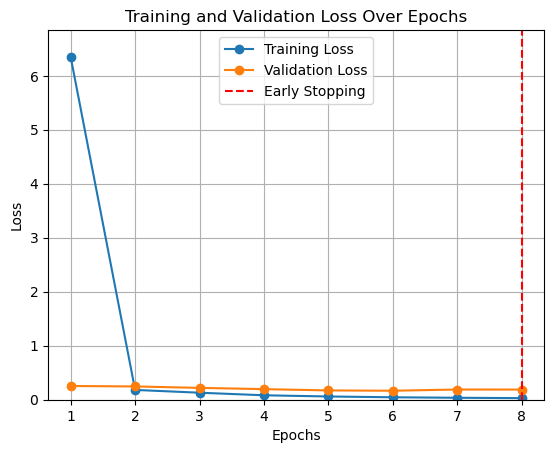

In [ ]:
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.grid(True)

early_stopping_epoch = 8
plt.axvline(x=early_stopping_epoch, color='red', linestyle='--', label='Early Stopping')
plt.legend()

# Adjust the axis so it looks nicer 
max_loss = max(max(train_losses), max(val_losses))
plt.ylim(0, max(max(train_losses), max(val_losses)) + 0.5)
plt.show()


In [ ]:
# Evaluate on test set
resnet_reg.eval()

# 
test_loss_reg = 0.0
test_preds_reg = []
test_targets_reg = []

with torch.no_grad():
    for images, log_prices in test_loader_reg:
        images, log_prices = images.to(device), log_prices.to(device).float()
        
        # Predictions
        outputs = resnet_reg(images).squeeze()
        
        # loss = MSE
        loss = loss_fn(outputs, log_prices)
        test_loss_reg += loss.item()
        
        # Pred and target
        test_preds_reg.extend(outputs.cpu().numpy())
        test_targets_reg.extend(log_prices.cpu().numpy())

# Calculate test loss
test_loss_reg /= len(test_loader_reg)

# Calculate R² 
test_r2_reg = r2_score(test_targets_reg, test_preds_reg)

# Back to $$ scale
test_preds_original = np.exp(test_preds_reg)
test_targets_original = np.exp(test_targets_reg)

# Calculate RMSE and R² in original scale
test_rmse_original = np.sqrt(mean_squared_error(test_targets_original, test_preds_original))
test_r2_original = r2_score(test_targets_original, test_preds_original)

# Print metrics
print(f"Test Loss (Log Scale): {test_loss_reg:.4f}")
print(f"Test R² (Log Scale): {test_r2_reg:.4f}")
print(f"Test RMSE (Original Scale): {test_rmse_original:.2f}")
print(f"Test R² (Original Scale): {test_r2_original:.4f}")


Test Loss (Log Scale): 0.1687
Test R² (Log Scale): 0.3439
Test RMSE (Original Scale): 325948.66
Test R² (Original Scale): 0.2847


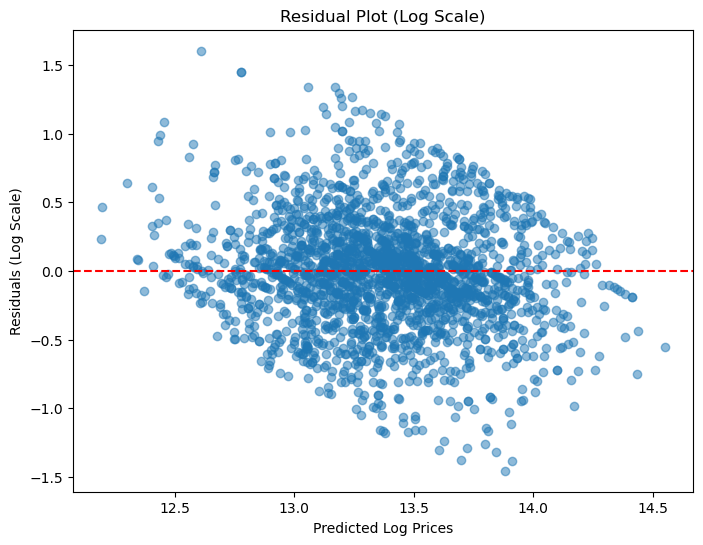

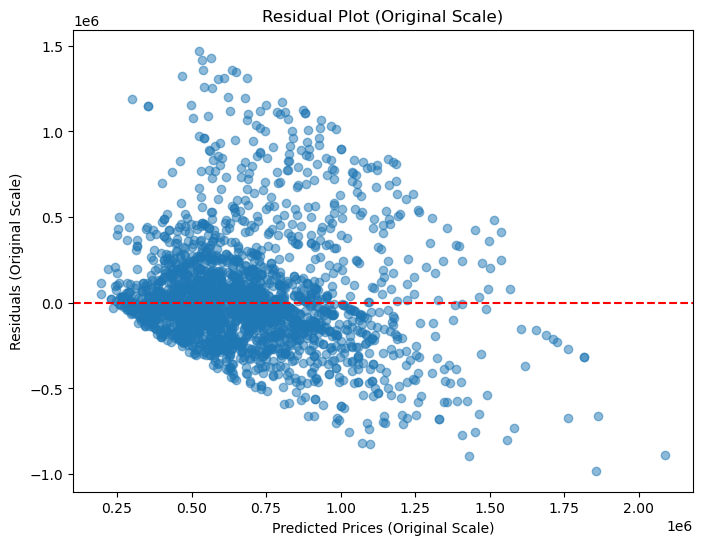

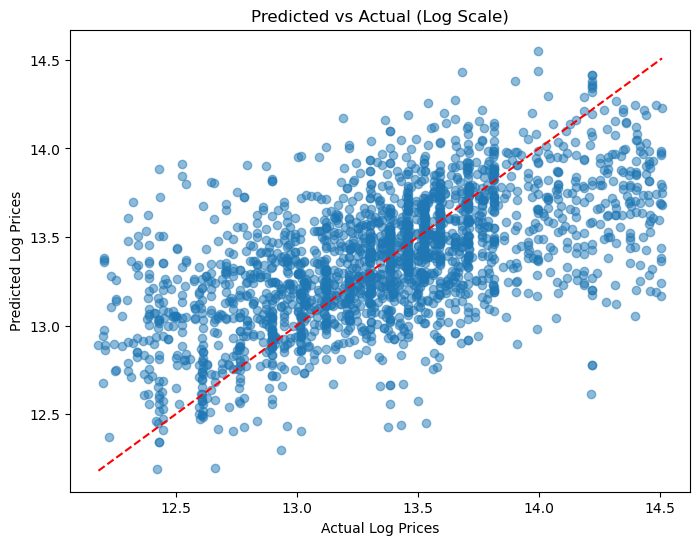

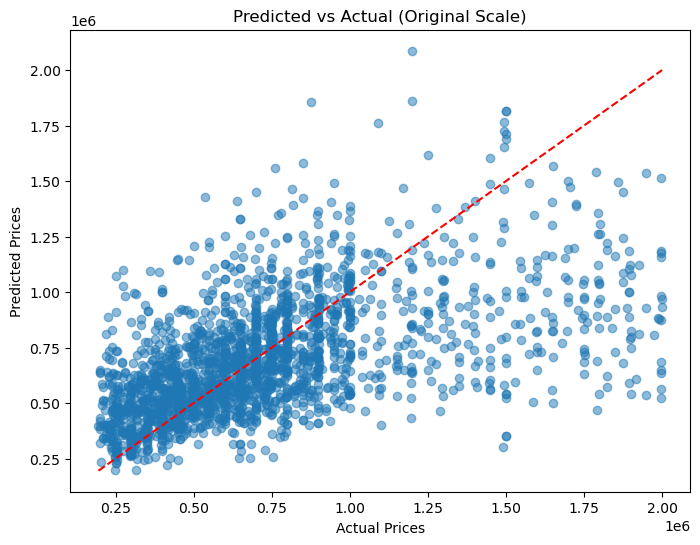

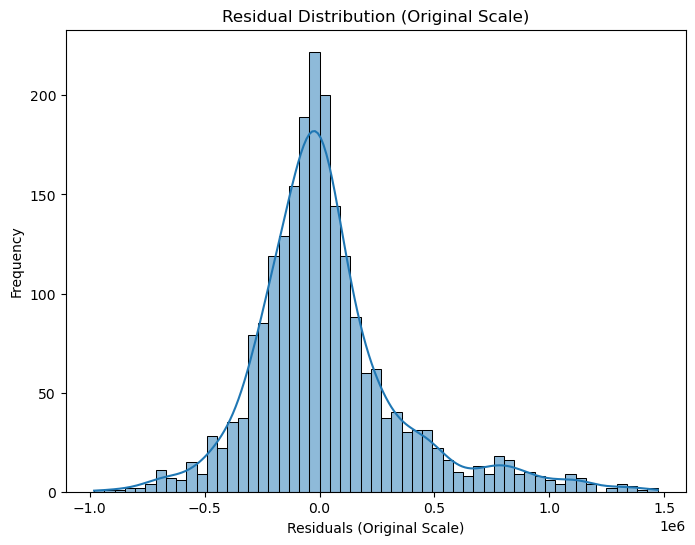

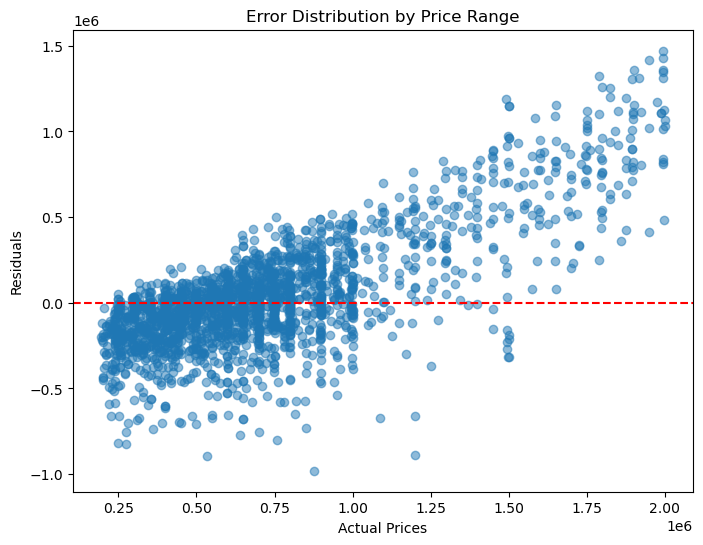

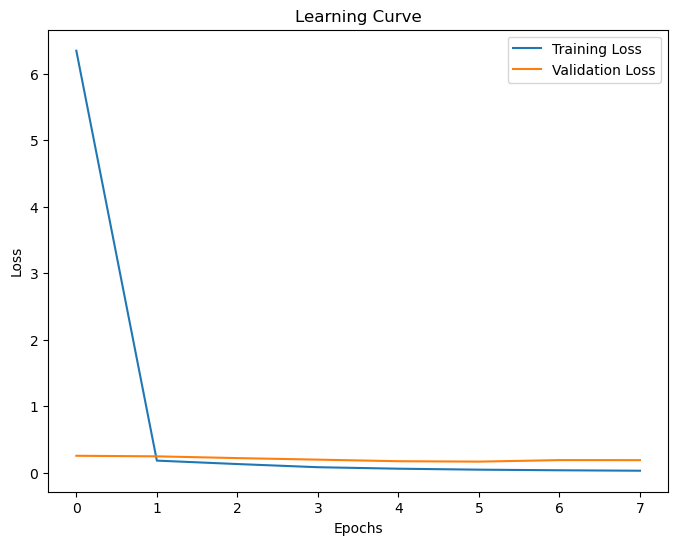

In [ ]:
## Every plot we can ever need - probably don't need all of them but just here for fun

# Residual Plot (Log Scale)
residuals = np.array(test_targets_reg) - np.array(test_preds_reg)
plt.figure(figsize=(8, 6))
plt.scatter(test_preds_reg, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Log Prices")
plt.ylabel("Residuals (Log Scale)")
plt.title("Residual Plot (Log Scale)")
plt.show()

# Residual Plot (Original Scale)
residuals_original = np.array(test_targets_original) - np.array(test_preds_original)
plt.figure(figsize=(8, 6))
plt.scatter(test_preds_original, residuals_original, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Prices (Original Scale)")
plt.ylabel("Residuals (Original Scale)")
plt.title("Residual Plot (Original Scale)")
plt.show()

# Predicted vs Actual (Log Scale)
plt.figure(figsize=(8, 6))
plt.scatter(test_targets_reg, test_preds_reg, alpha=0.5)
plt.plot([min(test_targets_reg), max(test_targets_reg)], 
         [min(test_targets_reg), max(test_targets_reg)], 'r--')
plt.xlabel("Actual Log Prices")
plt.ylabel("Predicted Log Prices")
plt.title("Predicted vs Actual (Log Scale)")
plt.show()

# Predicted vs Actual (Original Scale)
plt.figure(figsize=(8, 6))
plt.scatter(test_targets_original, test_preds_original, alpha=0.5)
plt.plot([min(test_targets_original), max(test_targets_original)], 
         [min(test_targets_original), max(test_targets_original)], 'r--')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted vs Actual (Original Scale)")
plt.show()

# Distribution of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals_original, kde=True)
plt.xlabel("Residuals (Original Scale)")
plt.ylabel("Frequency")
plt.title("Residual Distribution (Original Scale)")
plt.show()


# Error by Target Range
plt.figure(figsize=(8, 6))
plt.scatter(test_targets_original, residuals_original, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual Prices")
plt.ylabel("Residuals")
plt.title("Error Distribution by Price Range")
plt.show()

# Learning Curve
plt.figure(figsize=(8, 6))
plt.plot(range(len(train_losses)), train_losses, label="Training Loss")
plt.plot(range(len(val_losses)), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.show()


In [ ]:
# Load up the resnet we want
resnet_reg = models.resnet18(weights=None) 

# Change for price prediction
resnet_reg.fc = torch.nn.Linear(resnet_reg.fc.in_features, 1)  

# Best weights
weights_path = "/Users/maggiekleman/Desktop/MSBA/Advanced Machine Learning/Project/resnet_regression.pth"  
resnet_reg.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))
resnet_reg.eval()  

# Move the model to the appropriate device
resnet_reg.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
## This is the correct class for the tabular data loaders - I stored the other one in a separate file bc my computer was giving me errors

class HouseDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform, tabular_features, target_col, scaler=None):
        self.data = pd.read_csv(csv_file)
        self.image_folder = image_folder
        self.transform = transform
        self.tabular_features = tabular_features 
        self.target_col = target_col
        self.scaler = scaler  #
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_folder, row['image_id'])

        # Process image
        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            print(f"Image not found: {img_path}. Using placeholder image.")
            placeholder_path = os.path.join(self.image_folder, "placeholder.jpg")
            image = Image.open(placeholder_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Numerical
        tabular_data = row[self.tabular_features].values.astype(np.float32)

        # Target
        target = np.float32(row[self.target_col])

        return image, tabular_data, target



In [ ]:
# Standard resnet
transform = transforms.Compose([
    transforms.Resize((224, 224)),             
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]) 
])

# Paths
train_csv = 'train_split.csv'
val_csv = 'val_split.csv'
image_folder = '/Users/maggiekleman/Desktop/MSBA/Advanced Machine Learning/Project/socal_pics'

def preprocess_data(csv_file, image_folder, exclude_columns, target_col, reference_columns=None):
    data = pd.read_csv(csv_file)

    # price and path
    data['log_price'] = np.log(data['price'])
    data['image_id'] = data['image_id'].astype(str) + '.jpg'
    data['image_path'] = data['image_id'].apply(lambda x: os.path.join(image_folder, x))

    data.drop(columns=exclude_columns, errors='ignore', inplace=True)

    return data

# Drop these bc they aren't needed
exclude_columns = ['price', 'Unnamed: 0', 'street', 'citi', 'n_citi', 'City', 'State', 'closest_school', 'ZIP Code']

all_columns = pd.read_csv(train_csv).columns
target_col = 'log_price'

# Preprocess 
train_data = preprocess_data(train_csv, image_folder, exclude_columns, target_col)

# Preprocess
val_data = preprocess_data(val_csv, image_folder, exclude_columns, target_col)

# Store these for when i need to plot feature importance
tabular_features = [
    col for col in train_data.columns
    if col not in exclude_columns and col != target_col and not col.startswith(('image_'))
]

# merge these for rn
combined_data = pd.concat([train_data, val_data], ignore_index=True)

# Save everything so I can refer back
train_csv_cleaned = 'train_cleaned.csv'
val_csv_cleaned = 'val_cleaned.csv'
combined_csv_cleaned = 'combined_train_val_cleaned.csv'
train_data.to_csv(train_csv_cleaned, index=False)
val_data.to_csv(val_csv_cleaned, index=False)
combined_data.to_csv(combined_csv_cleaned, index=False)

# Dataloaders
batch_size = 32
train_dataset = HouseDataset(train_csv_cleaned, image_folder, transform, tabular_features, target_col)
val_dataset = HouseDataset(val_csv_cleaned, image_folder, transform, tabular_features, target_col)
combined_dataset = HouseDataset(combined_csv_cleaned, image_folder, transform, tabular_features, target_col)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

#  Check to see that everything matches
for images, tabular_data, targets in train_loader:
    print(f"Train Image batch shape: {images.shape}")
    print(f"Train Tabular batch shape: {tabular_data.shape}")
    print(f"Train Target batch shape: {targets.shape}")
    break

for images, tabular_data, targets in val_loader:
    print(f"Validation Image batch shape: {images.shape}")
    print(f"Validation Tabular batch shape: {tabular_data.shape}")
    print(f"Validation Target batch shape: {targets.shape}")
    break

for images, tabular_data, targets in combined_loader:
    print(f"Combined Image batch shape: {images.shape}")
    print(f"Combined Tabular batch shape: {tabular_data.shape}")
    print(f"Combined Target batch shape: {targets.shape}")
    break


Initial data shape: (6978, 32)
Initial data shape: (1745, 32)
Train Image batch shape: torch.Size([32, 3, 224, 224])
Train Tabular batch shape: torch.Size([32, 21])
Train Target batch shape: torch.Size([32])
Validation Image batch shape: torch.Size([32, 3, 224, 224])
Validation Tabular batch shape: torch.Size([32, 21])
Validation Target batch shape: torch.Size([32])
Combined Image batch shape: torch.Size([32, 3, 224, 224])
Combined Tabular batch shape: torch.Size([32, 21])
Combined Target batch shape: torch.Size([32])


In [ ]:


# Save tabular features to a JSON file
features_file = "tabular_features.json"
with open(features_file, "w") as f:
    json.dump(tabular_features, f)
print(f"Tabular features saved to {features_file}")

print(tabular_features)

Tabular features saved to tabular_features.json
['bed', 'bath', 'sqft', 'population', 'income', 'poverty', 'latitude', 'longitude', 'distance_to_Downtown_Los_Angeles', 'distance_to_Santa_Monica', 'distance_to_San_Diego', 'distance_to_Irvine', 'distance_to_Pasadena', 'school_rating', 'school_distance', 'restaurant_distance', 'grocery_distance', 'park_distance', 'hospital_distance', 'year_built', 'lot_size']


In [17]:
# Class to extract features from images 

class FeatureExtractor(nn.Module):
    def __init__(self, resnet_model):
        super(FeatureExtractor, self).__init__()

        self.features = nn.Sequential(*list(resnet_model.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  
        return x

resnet_features = FeatureExtractor(resnet_reg)
resnet_features.eval()
resnet_features.to(device)


FeatureExtractor(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [18]:
# Extract features function
def extract_features(dataloader, feature_extractor, device):
    image_features = []
    tabular_features = []
    targets = []

    with torch.no_grad():
        for images, tabular_data, target in dataloader:
            images = images.to(device)
            features = feature_extractor(images)
            image_features.append(features.cpu().numpy())
            tabular_features.append(tabular_data.numpy())
            targets.append(target.numpy())

    image_features = np.vstack(image_features)
    tabular_features = np.vstack(tabular_features)
    targets = np.concatenate(targets)
    return image_features, tabular_features, targets


In [19]:
# Extract features - training set
combined_image_features, combined_tabular_features, combined_targets = extract_features(
    combined_loader, resnet_features, device
)


## Save Training Features as NPY file for easy retrieval

In [20]:
np.save('combined_image_features.npy', combined_image_features)
np.save('combined_tabular_features.npy', combined_tabular_features)
np.save('combined_targets.npy', combined_targets)

In [ ]:
combined_image_features = np.load('combined_image_features.npy')
combined_tabular_features = np.load('combined_tabular_features.npy')
combined_targets = np.load('combined_targets.npy')

# Combine features
combined_features = np.hstack([combined_tabular_features, combined_image_features])

## Process Held Out Testing Data

In [ ]:
# Preprocess Test Data - The exact same process as for train and val
test_data = pd.read_csv('/Users/maggiekleman/Desktop/MSBA/Advanced Machine Learning/Project/test_set_1.csv')
print(f"Initial test data shape: {test_data.shape}")
test_data['log_price'] = np.log(test_data['price'])


test_data['image_id'] = test_data['image_id'].astype(str) + '.jpg'
test_data['image_path'] = test_data['image_id'].apply(lambda x: os.path.join(image_folder, x))


test_data = test_data[test_data['image_path'].apply(os.path.exists)]
test_data = test_data.reindex( fill_value=0)

test_csv_cleaned = 'test_cleaned.csv'
test_data.to_csv(test_csv_cleaned, index=False)

test_dataset = HouseDataset(test_csv_cleaned, image_folder, transform, tabular_features, target_col)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

test_image_features, test_tabular_features, test_targets = extract_features(
    test_loader, resnet_features, device
)

test_combined_features = np.hstack([test_tabular_features, test_image_features])

np.save('test_combined_features.npy', test_combined_features)
np.save('test_combined_targets.npy', test_targets)
np.save('test_tabular_features.npy', test_tabular_features)
np.save('test_image_features.npy', test_image_features)


Initial test data shape: (2727, 31)


In [ ]:
# load my saved features

test_targets = np.load('test_combined_targets.npy')
test_combined_features = np.load('test_combined_features.npy')
test_image_features = np.load('test_image_features.npy')
test_tabular_features = np.load('test_tabular_features.npy')

## XGBoost with PCA

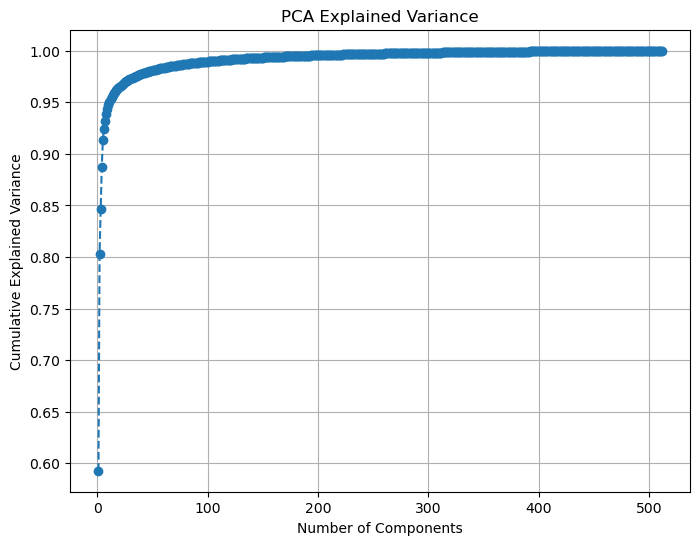

Number of components to retain 95% variance: 11


In [ ]:

# PCA implementation
pca = PCA()
pca.fit(combined_image_features)

# explained variance plot
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

# How many components to retain 95% of variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1  
print(f"Number of components to retain 95% variance: {n_components_95}")


In [ ]:
#Split
X_tabular_train, X_tabular_val, X_image_train, X_image_val, y_train, y_val = train_test_split(
    combined_tabular_features,
    combined_image_features,
    combined_targets,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)

# scale
scaler_tabular = StandardScaler()
scaled_tabular_train = scaler_tabular.fit_transform(X_tabular_train)
scaled_tabular_val = scaler_tabular.transform(X_tabular_val)

# PCA
pca = PCA(n_components=11)
image_features_pca_train = pca.fit_transform(X_image_train)
image_features_pca_val = pca.transform(X_image_val)

# Scale
scaler_image = StandardScaler()
scaled_image_features_train = scaler_image.fit_transform(image_features_pca_train)
scaled_image_features_val = scaler_image.transform(image_features_pca_val)

X_train = np.hstack([scaled_tabular_train, scaled_image_features_train])
X_val = np.hstack([scaled_tabular_val, scaled_image_features_val])

# Merge test features after scaling
scaled_test_tabular_features = scaler_tabular.transform(test_tabular_features)
test_image_features_pca = pca.transform(test_image_features)
scaled_test_image_features = scaler_image.transform(test_image_features_pca)
scaled_test_combined_features = np.hstack([scaled_test_tabular_features, scaled_test_image_features])

# Had to use this bc my computer hates xgboost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(scaled_test_combined_features, label=test_targets)

# This is the optuna implementation that i researched
def objective(trial):
    # grid
    param = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
    }


    # train for the study
    evals = [(dtrain, "train"), (dval, "eval")]
    model = xgb.train(
        params=param,
        dtrain=dtrain,
        num_boost_round=1000,
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=False
    )

    # val pred
    y_val_pred_log = model.predict(dval)

    # back to original scale
    y_val_pred = np.exp(y_val_pred_log)
    y_val_original = np.exp(y_val)

    # RMSE
    rmse = np.sqrt(mean_squared_error(y_val_original, y_val_pred))
    return rmse


In [ ]:
# Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# print best
print("Best RMSE:", study.best_value)
print("Best Parameters:", study.best_params)


[I 2024-12-11 16:20:33,199] A new study created in memory with name: no-name-976a0ee4-a354-49a4-b05a-458ecdc32fd9
[I 2024-12-11 16:20:34,830] Trial 0 finished with value: 136749.609375 and parameters: {'max_depth': 4, 'learning_rate': 0.15983367836499973, 'subsample': 0.9434050288435649, 'colsample_bytree': 0.8538114873047902, 'lambda': 0.06676328821183247, 'alpha': 5.81897451995683}. Best is trial 0 with value: 136749.609375.
[I 2024-12-11 16:20:36,201] Trial 1 finished with value: 137028.9375 and parameters: {'max_depth': 4, 'learning_rate': 0.22678281295902586, 'subsample': 0.894631359046014, 'colsample_bytree': 0.650481343724793, 'lambda': 0.024373717380105724, 'alpha': 0.44804451379268073}. Best is trial 0 with value: 136749.609375.
[I 2024-12-11 16:20:40,291] Trial 2 finished with value: 154993.65625 and parameters: {'max_depth': 9, 'learning_rate': 0.16127356674154378, 'subsample': 0.5743337108282429, 'colsample_bytree': 0.6769886751195534, 'lambda': 0.04005550926293754, 'alpha'

Best RMSE: 129839.640625
Best Parameters: {'max_depth': 5, 'learning_rate': 0.056811844410370176, 'subsample': 0.909349809705431, 'colsample_bytree': 0.7121052757907993, 'lambda': 0.5361238069794813, 'alpha': 0.0812078942282934}


In [ ]:
# Use best params
best_params = study.best_params

final_model = xgb.train(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=[(dtrain, "train")],
    early_stopping_rounds=50,
    verbose_eval=True
)

[0]	train-rmse:0.48833
[1]	train-rmse:0.47121
[2]	train-rmse:0.45644
[3]	train-rmse:0.44287
[4]	train-rmse:0.42983
[5]	train-rmse:0.41687
[6]	train-rmse:0.40680
[7]	train-rmse:0.39326
[8]	train-rmse:0.38317
[9]	train-rmse:0.37264
[10]	train-rmse:0.36143
[11]	train-rmse:0.35276
[12]	train-rmse:0.34334
[13]	train-rmse:0.33565
[14]	train-rmse:0.32657
[15]	train-rmse:0.31905
[16]	train-rmse:0.31058
[17]	train-rmse:0.30353
[18]	train-rmse:0.29606
[19]	train-rmse:0.28860
[20]	train-rmse:0.28191
[21]	train-rmse:0.27682
[22]	train-rmse:0.27110
[23]	train-rmse:0.26584
[24]	train-rmse:0.26076
[25]	train-rmse:0.25640
[26]	train-rmse:0.25146
[27]	train-rmse:0.24671
[28]	train-rmse:0.24221
[29]	train-rmse:0.23831
[30]	train-rmse:0.23451
[31]	train-rmse:0.23113
[32]	train-rmse:0.22819
[33]	train-rmse:0.22534
[34]	train-rmse:0.22194
[35]	train-rmse:0.21888
[36]	train-rmse:0.21604
[37]	train-rmse:0.21351
[38]	train-rmse:0.21068
[39]	train-rmse:0.20811
[40]	train-rmse:0.20587
[41]	train-rmse:0.20356
[4

In [ ]:
y_test_pred_log = final_model.predict(dtest)
y_test_pred = np.exp(y_test_pred_log)


y_test_original = np.exp(test_targets)
test_rmse = np.sqrt(mean_squared_error(y_test_original, y_test_pred))
test_r2 = r2_score(y_test_original, y_test_pred)

print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R^2: {test_r2:.4f}")

Test RMSE: 209014.5469
Test R^2: 0.6965


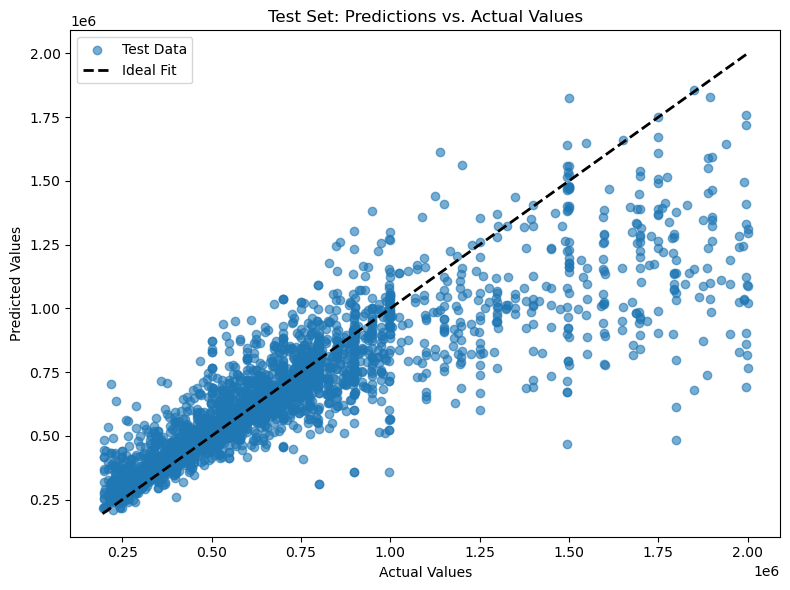

In [ ]:
# Plot Test Predictions vs. Actuals
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_test_pred, alpha=0.6, label='Test Data')
plt.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], 
         'k--', lw=2, label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Test Set: Predictions vs. Actual Values')
plt.legend()
plt.tight_layout()
plt.show()

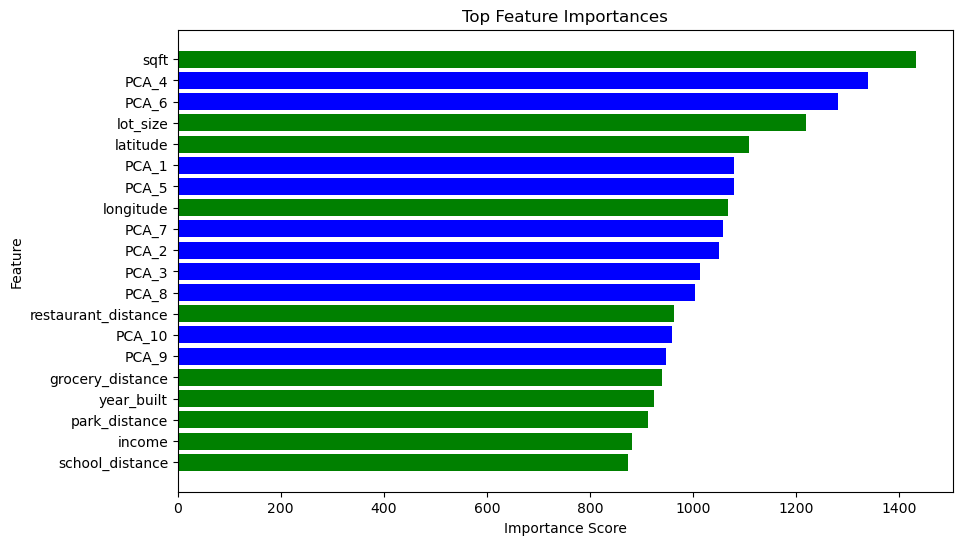

In [ ]:
# Load the features taht I stored earlier
with open('tabular_features.json', 'r') as f:
    tabular_feature_names = json.load(f) 

# PCA features
n_pca_features = 11  

# Make names for these
pca_feature_names = [f'PCA_{i+1}' for i in range(n_pca_features)]

# Merge
all_feature_names = tabular_feature_names + pca_feature_names

# Extract importance
feature_importance = final_model.get_score(importance_type='weight')  # 'weight', 'gain', or 'cover'

# names to features
importance_data = {
    all_feature_names[int(key[1:])]: value  # Extract numeric index from 'f0', 'f1', etc.
    for key, value in feature_importance.items()
}

importance_df = pd.DataFrame(list(importance_data.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)


# top 20
top_n = 20
top_features = importance_df.head(top_n)

# different colors
colors = ['blue' if 'PCA' in feature else 'green' for feature in top_features['Feature']]

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color=colors, align='center')
plt.gca().invert_yaxis()
plt.title('Top Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


